In [7]:
import torch
from phasegrok.data_gen import generate_data
from phasegrok.utils import Logger, get_loss
import numpy as np
from tqdm import tqdm
from boilerplate.utils.utils import make_path, make_grid, get_lims
from torchmetrics.functional import accuracy
from time import strftime
import glob 
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from tbparse import SummaryReader
plt.style.use('mystyle-bright')

cmap = cm.get_cmap('viridis_r', 256)
array = cmap(np.linspace(0, 1, 256)) + np.array([0.2, 0.1, 0, 0])
array = (array - array.min()) / (array.max() - array.min())
newcolors = mcolors.ListedColormap(array)

In [2]:
seed = 0
split_ratio = 0.8
p = 11
m = 11
torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=True,
                                                      batch_size=-1, compute_best_acc=False)
print(f"Best acc: {best_acc}")                                          

Best acc: None


In [3]:
seed_weights = 2 #1
latent_dim = 2
device = 'cpu'
depth = 5 # 1
width = 256#128
weight_decay  = 10 # 5
dropout = 0.0
log_step = 100
nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim)) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation = representation.to(device).requires_grad_()
out_classes = m if m > 1 else 2 * p - 1


model = [torch.nn.Linear(latent_dim, width), torch.nn.LeakyReLU(), torch.nn.Dropout(dropout)]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.ReLU(), torch.nn.Dropout(dropout)) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 1e-3, #1e-3
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 1e-5, #2e-4
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
loss_func = get_loss('cross_entropy')

def step(idx):
    x = representation[idx]
    x = x.sum(1)
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], 'epoch': []}

logger = Logger(experiment="ModAdd2Dbad", log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 20000
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = 'final' #strftime("%Y%m%d-%H%M")


Overwriting /home/kitouni/projects/Grok/grokking-squared/runs/ModAdd2Dbad/


Loss 5.21e-03|1.23e+02 || Acc 1.000|0.077: 100%|██████████| 20000/20000 [02:55<00:00, 113.66it/s]

saved to /home/kitouni/projects/Grok/grokking-squared/runs/ModAdd2Dbad/


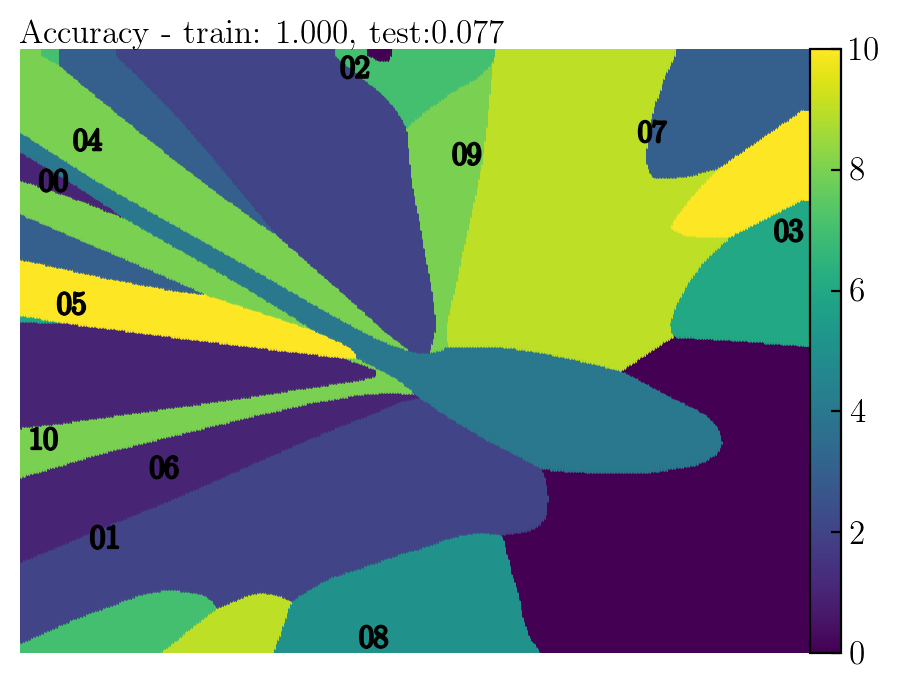

In [10]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/ModAdd2Dbad/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 500

n = len(representation_files) - 1
indices = [n]

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"Accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes, fontsize='large')
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1)
    sc = plt.scatter(*grid.T, c=pred, zorder=0, cmap='viridis', marker='s', s=4)
    cbar = plt.colorbar(sc, pad=0)
    cbar.set_ticks(np.arange(0, out_classes, 2))
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = plt.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])
    ax.set_axis_off()
    xlim, ylim = get_lims(grid, 0.01)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    name = path.split("/")[-1]
    plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')

# Good Rep

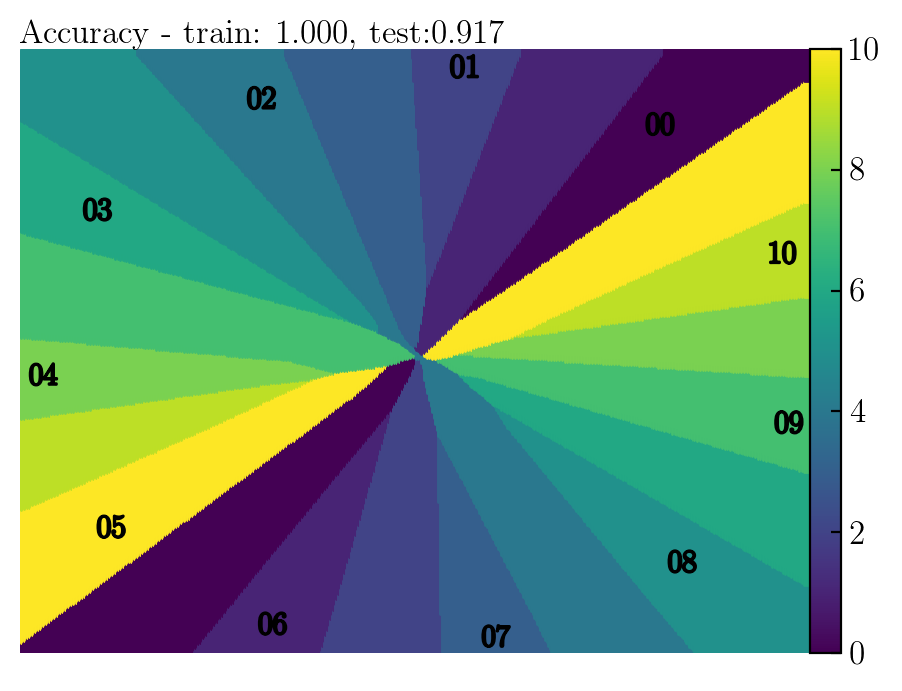

In [11]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/ModAdd2Dgood/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 500

n = len(representation_files) - 1
indices = [n]

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"Accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes, fontsize='large')
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1)
    sc = plt.scatter(*grid.T, c=pred, zorder=0, cmap='viridis', marker='s', s=4)
    cbar = plt.colorbar(sc, pad=0)
    cbar.set_ticks(np.arange(0, out_classes, 2))
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = plt.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])
    ax.set_axis_off()
    xlim, ylim = get_lims(grid, 0.01)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    name = path.split("/")[-1]
    plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')